## **Imports**

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
)

## **Paths & Global Variables**

In [2]:
ROOT_PATH = r"C:\Users\mario\OneDrive\Documents\Work\Side Hustles\Kaggle\titanic"
TARGET_VAR = "survived"
COLINEARITY_THRESHOLD = 0.4

import sys

sys.path.append(ROOT_PATH)

from titanic.config import PROCESSED_DATA_DIR, MODELS_DIR

2025-02-23 21:23:20.225 | INFO     | titanic.config:<module>:9 - PROJ_ROOT path is: C:\Users\mario\OneDrive\Documents\Work\Side Hustles\Kaggle\titanic


## **Reading Data**

In [3]:
os.chdir(PROCESSED_DATA_DIR)

# features_selected = pd.read_json("log_reg_features.json").index.to_list()

X_train = pd.read_parquet("X_train.parquet")
y_train = pd.read_parquet("y_train.parquet")

X_test = pd.read_parquet("X_val.parquet")
y_test = pd.read_parquet("y_val.parquet")

# **Logistic Regression**

In [4]:
cols_to_remove = [
    "passenger_class_ord",
    "num_rooms",
    "title_lcode",
    "cabin_level_1_B",
    "cabin_level_1_E",
    "cabin_level_1_D",
]
X_train.drop(columns=cols_to_remove, inplace=True)
X_test.drop(columns=cols_to_remove, inplace=True)

## **Model Fitting**

### **Balance Class Weight**

In [5]:
log_reg = LogisticRegression(
    class_weight="balanced", penalty="l2", solver="liblinear", C=1.0
)

In [6]:
# finds the coefficients and the intercept value
log_reg.fit(X_train, y_train.values.ravel())

LogisticRegression(class_weight='balanced', solver='liblinear')

## **Model Testing**

### **Classification Threshold**

In [7]:
THRESHOLD = 0.5
# Doesn't affect Gini acore but affects the confusion matrix
# Do you want to be more sensitive to false positives or false negatives?

In [8]:
y_predicted_probs = log_reg.predict_proba(X_test)[:, 1]
if THRESHOLD == 0.5:
    y_predicted = log_reg.predict(X_test)
else:
    y_predicted = (y_predicted_probs > THRESHOLD) * 1.0

In [9]:
y_predicted_df = pd.DataFrame(y_predicted, columns=["predicted"], index=X_test.index)
y_predicted_probs_df = pd.DataFrame(
    y_predicted_probs, columns=["probability"], index=X_test.index
)
y_predicted_df = pd.concat([y_predicted_df, y_predicted_probs_df], axis=1)
y_predicted_df.head()

,predicted,probability
passenger_id,,
161,False,0.095032
127,False,0.233991
429,False,0.233991
423,False,0.120843
566,False,0.119404


## **Evaluation Metrics**

In [10]:
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predicted),
    index=["actual no", "actual yes"],
    columns=["predicted no", "predicted yes"],
)

test_conf_matrix

,predicted no,predicted yes
actual no,88,22
actual yes,15,53


In [11]:
metrics_dict = {
    "Accuracy": accuracy_score(y_test, y_predicted),
    "Precision": precision_score(y_test, y_predicted),
    "Recall": recall_score(y_test, y_predicted),
    "F1 Score": f1_score(y_test, y_predicted),
}

metrics_df = pd.DataFrame(
    metrics_dict.values(), index=metrics_dict.keys(), columns=["Value"]
)

roc_auc = roc_auc_score(y_test, y_predicted_probs)
gini = 2 * roc_auc - 1

metrics_df.loc["ROC AUC"] = roc_auc
metrics_df.loc["Gini"] = gini

metrics_df

,Value
Accuracy,0.792135
Precision,0.706667
Recall,0.779412
F1 Score,0.741259
ROC AUC,0.855348
Gini,0.710695


## **Mean Squared Error**

In [12]:
pred_train = log_reg.predict(X_train)
pred_test = log_reg.predict(X_test)
training_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)
print("Training Error:", training_mse)
print("Test Error:", test_mse)

Training Error: 0.19690576652601968
Test Error: 0.20786516853932585


## **Feature Importance**

C:\Users\mario\AppData\Local\Temp\ipykernel_12816\2882998531.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: xlabel='Coefficient', ylabel='Feature'>

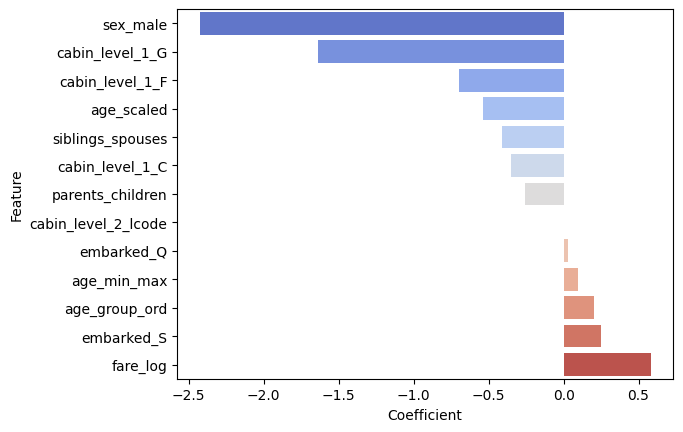

In [13]:
coefficients_df = pd.DataFrame(
    {"Feature": log_reg.feature_names_in_, "Coefficient": log_reg.coef_.flatten()}
)

sns.barplot(
    x="Coefficient",
    y="Feature",
    data=coefficients_df.sort_values("Coefficient"),
    palette="coolwarm",
)

## **Model & Prediction Export**

In [14]:
os.chdir(MODELS_DIR)
# Save model
joblib.dump(log_reg, "log_reg-ridge-model.joblib")
y_predicted_df.to_parquet("log_reg-ridge-y_predicted.parquet")